In [146]:
import tensorflow as tf
tf.random.set_seed(42)
from kerasbeats import prep_time_series, NBeatsModel
from tensorflow import keras
import numpy as np
import pandas as pd


def create_nbeat_mlp(num_columns, num_labels, lookback, horizon, hidden_units, dropout_rates, batch_size, ls=1e-2, lr=1e-3, ):
    nbeats = NBeatsModel(model_type = 'generic', lookback = lookback, horizon = horizon,
                         learning_rate = lr, batch_size = batch_size,
                         num_generic_neurons = hidden_units[0]) # set as default
    nbeats.build_layer()
    time_input = keras.layers.Input(shape = (lookback * horizon, ))
    x_nb = nbeats.model_layer(time_input)

    xcons = keras.layers.Input(shape = (num_columns, ))
    x = keras.layers.Concatenate()([xcons, x_nb])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)

    for i in range(1, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i])(x)

    out = tf.keras.layers.Dense(num_labels, name = 'action')(x)
    model = tf.keras.models.Model(inputs = [time_input, xcons], outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss = {'action' : tf.keras.losses.MeanSquaredError()},
                  metrics = {'action' : tf.metrics.MeanSquaredError(name = 'mse')})
    return model

In [147]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from itertools import islice
import tscv

def generate_label(df, threshold = 0.002):
    df['label'] = 0
    df.loc[(df['target_15m'] <= -1*threshold), 'label'] = 1
    df.loc[(df['target_15m'] >= threshold), 'label'] = 2
    return df

def get_na_features(df, train_features):
    tmp = pd.DataFrame(df[train_features].isnull().sum())
    tmp = tmp[tmp[0] > 0].reset_index()
    tmp.columns = ['feat', 'cnt']
    tmp = tmp.sort_values('cnt')
    feat_groups = dict(tmp.groupby('cnt')['feat'].agg(lambda x: list(x)))
    return feat_groups

In [148]:
def normalize_columns_infer(df, means, stds):
    features = means.index.tolist()
    for feature in features:
        mean = means.loc[feature]
        std = stds.loc[feature]
        df[feature] = (df[feature] - mean) / std
    return df

In [149]:
window = 30
file = f'mean_corr_new_features.csv'
corr = pd.read_csv(f'../output/feature_corr/{file}', header = 0, index_col = 0)

import joblib

std_dev_percentiled = joblib.load('../data/std_ranges_percentiled.joblib')
min_max_percentiled = joblib.load('../data/min_max_ranges_percentiled.joblib')

In [150]:
def get_percentile(value, percentiles):
    for ind, range_value in enumerate(percentiles):
        percentile = (ind + 1) / 100
        if value < range_value:
            return percentile
    return 1

In [151]:
train = False
df = pd.read_feather('../data/df_btc_with_features_5m_spot_new_features.feather')

df['target_5m'] = df['close'].pct_change(1)
df['close_5m'] = df['close'].shift(-1)
df['close_t'] = df['close'].copy()
start_time = df['open_time'].min()
end_time = df['open_time'].max()
dates = df['open_time'].unique()
n = len(dates)

df['std_5m'] = df['close'].rolling(100).std()
df['min_max'] = df['close'].rolling(100).apply(lambda x: x.max() / x.min())

df['std_dev_percentile'] = df['std_5m'].apply(lambda x: get_percentile(x, std_dev_percentiled))
df['min_max_percentile'] = df['min_max'].apply(lambda x: get_percentile(x, min_max_percentiled))
df['sample_weights'] = np.sqrt(df['min_max_percentile'] * df['std_dev_percentile'])

train_idx = int(0.7 * n)
valid_idx = int(0.8 * n)
train_end = dates[train_idx]
valid_end = dates[valid_idx]

train_df = df.loc[df['open_time'] < train_end].reset_index(drop=True)
valid_df = df.loc[(train_end <= df['open_time']) & (df['open_time'] < valid_end)].reset_index(drop=True)
train_df = pd.concat([train_df, valid_df], axis = 0)

test_df = df.loc[(df['open_time'] >= valid_end)].reset_index(drop=True)
valid_df = test_df.copy()

groups = pd.factorize(
    train_df['open_time'].dt.day.astype(str) + '_' + train_df['open_time'].dt.month.astype(str) + '_' + train_df[
        'open_time'].dt.year.astype(str))[0]

cv = tscv.PurgedGroupTimeSeriesSplit(
    n_splits=5,
    group_gap=5,
)

In [152]:
from joblib import load, dump
from sklearn.preprocessing import MinMaxScaler


directory = f'nbeats_wt_mse_rets_1206'
scaler = load(f'../output/{directory}/scaler.joblib')

lookback = 3
horizon = 100

batch_size = 1024
lookback = 3
params = {
    "model_type" : "generic",
    "lookback" : lookback,
    "horizon" : 100,
    "learning_rate" : 1e-3
}

valid_df = valid_df.drop(['target_5m'], axis = 1).rename({'close' : 'target_5m'}, axis = 1)
x_valid = scaler.transform(valid_df['target_5m'].values.reshape(-1, 1))

x_val, y_val = prep_time_series(x_valid.flatten(), lookback = lookback, horizon = horizon)
cutoff_val = valid_df.shape[0] - x_val.shape[0]

/Users/johnz/anaconda3/envs/python310/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [153]:
fold = 4
model = NBeatsModel(**params)
model.build_layer()
model.build_model()
model.model.load_weights(f'../output/{directory}/NBEATS_MSE_{fold}_price_min_max_{lookback}_base.hdf5')

preds = model.predict(x_val)


4119/4119 [==============================] - 148s 35ms/step


In [154]:
misc_feats = ['close_t', 'close_5m', 'open_time', 'target_5m', 'sample_weights', 'std_5m', 'min_max']
x_val_cons = valid_df[misc_feats].iloc[(lookback * horizon) - 1:-horizon]
print(f'Shape of X_const is {x_val_cons.shape}, x_val is {x_val.shape}, y_val is {y_val.shape}')

Shape of X_const is (131789, 7), x_val is (131789, 300), y_val is (131789, 100)


In [155]:
x_time, y_time = prep_time_series(valid_df['open_time'], lookback = lookback, horizon = horizon)

In [156]:
x_val, y_val = prep_time_series(valid_df['target_5m'], lookback = lookback, horizon = horizon)

In [157]:
x_val_price, y_val_price = prep_time_series(valid_df['close_t'], lookback = lookback, horizon = horizon)

In [158]:
valid_df['target_5m']

0         20074.62
1         20086.42
2         20077.86
3         20072.49
4         20073.52
            ...   
132183    41904.71
132184    41872.00
132185    41950.01
132186    41999.99
132187    41991.10
Name: target_5m, Length: 132188, dtype: float64

# if analysis is returns

In [160]:
from tqdm import tqdm
ypreds, ytrues, dates, ret_pred, ret_true, weights = [], [], [], [], [], []
is_return = False
for i, (idx, row) in tqdm(enumerate(x_val_cons.iterrows())):
    ypred = preds[i, :]
    if is_return:
        cum_rets = (1 + ypred).cumprod() - 1
        prices = (1 + cum_rets) * row['close_t']
        ret_pred.append(ypred)
        ytrue_ret = y_val[i, :]
        ret_true.append(ytrue_ret)
    else:
        prices = scaler.inverse_transform(ypred.reshape(-1, 1))
    dates.append(row['open_time'])
    ypreds.append(prices)
    ytrue_price = y_val_price[i, :]
    ytrues.append(ytrue_price)
    weights.append(row['sample_weights'])


131789it [00:23, 5565.67it/s]


In [161]:
def calculate_weighted_rmse(predictions: np, actual: np) -> float:
    predictions = np.array(predictions)
    actual = np.array(actual)

    k = 0.001

    weights = np.exp(-k * np.arange(len(predictions)))
    weighted_squared_errors = weights * (predictions - actual) ** 2
    weighted_rmse = np.sqrt(np.sum(weighted_squared_errors) / np.sum(weights))

    return weighted_rmse

In [162]:
def get_weights(ytrue_price_i):
    std_dev_percentiled = joblib.load('../data/std_ranges_percentiled.joblib')
    min_max_percentiled = joblib.load('../data/min_max_ranges_percentiled.joblib')
    std = ytrue_price_i.std()
    minmax = ytrue_price_i.max() / ytrue_price_i.min()
    std_pct = get_percentile(std, std_dev_percentiled)
    minmax_pct = get_percentile(minmax, min_max_percentiled)
    return np.sqrt(std_pct * minmax_pct), minmax, std

In [163]:
from sklearn.metrics import r2_score
from tqdm import tqdm
rmse, r2, minmax, std, wts = [], [], [], [], []
for i in tqdm(range(len(ypreds))):
    date = dates[i]
    ypred_price_i = ypreds[i]
    ytrue_price_i = ytrues[i]
    wts = weights[i]
    score = calculate_weighted_rmse(ytrue_price_i, ypred_price_i)
    actual_wts, minmax, std = get_weights(ytrue_price_i)
    wt_score = actual_wts * score
    rmse.append((date, wt_score, score, wts, actual_wts, std, minmax))

100%|██████████| 131789/131789 [01:02<00:00, 2099.61it/s]


In [164]:
rmse_df = pd.DataFrame(rmse, columns = ['open_time', 'weighted_rmse',
                                        'rmse', 'weights', 'act_weights', 'std', 'minmax'])

In [168]:
rmse_df[['weights', 'act_weights']].corr()

,weights,act_weights
weights,1.000000,0.305296
act_weights,0.305296,1.000000


In [169]:
rmse_df.mean()

open_time        2023-04-19 19:49:35.549552896
weighted_rmse                       829.402581
rmse                                1744.13016
weights                               0.273293
act_weights                           0.272938
std                                  97.939896
minmax                                1.016191
dtype: object

In [170]:
rmse_df.std()

open_time        132 days 02:55:56.630580164
weighted_rmse                    1675.803254
rmse                             1740.327123
weights                             0.246603
act_weights                          0.24634
std                                98.160878
minmax                              0.014425
dtype: object

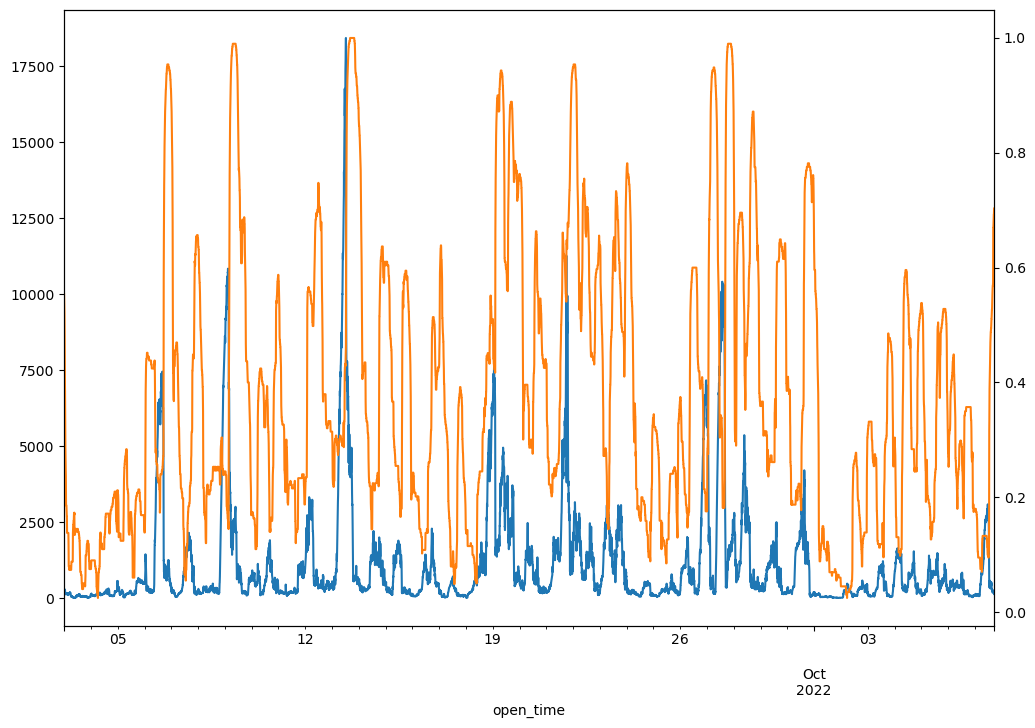

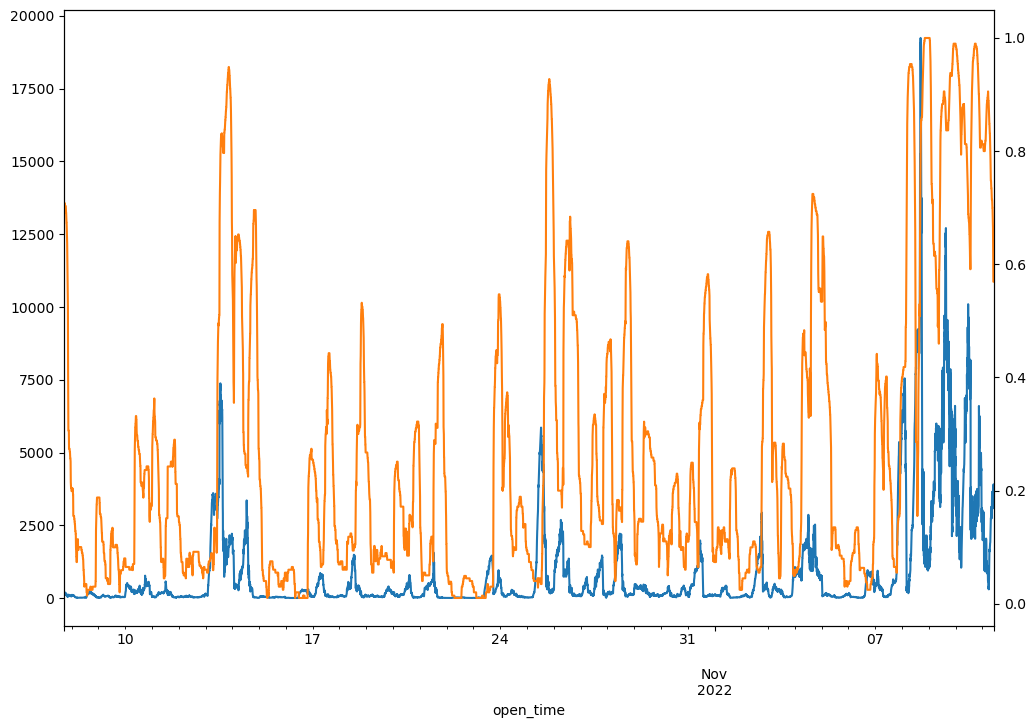

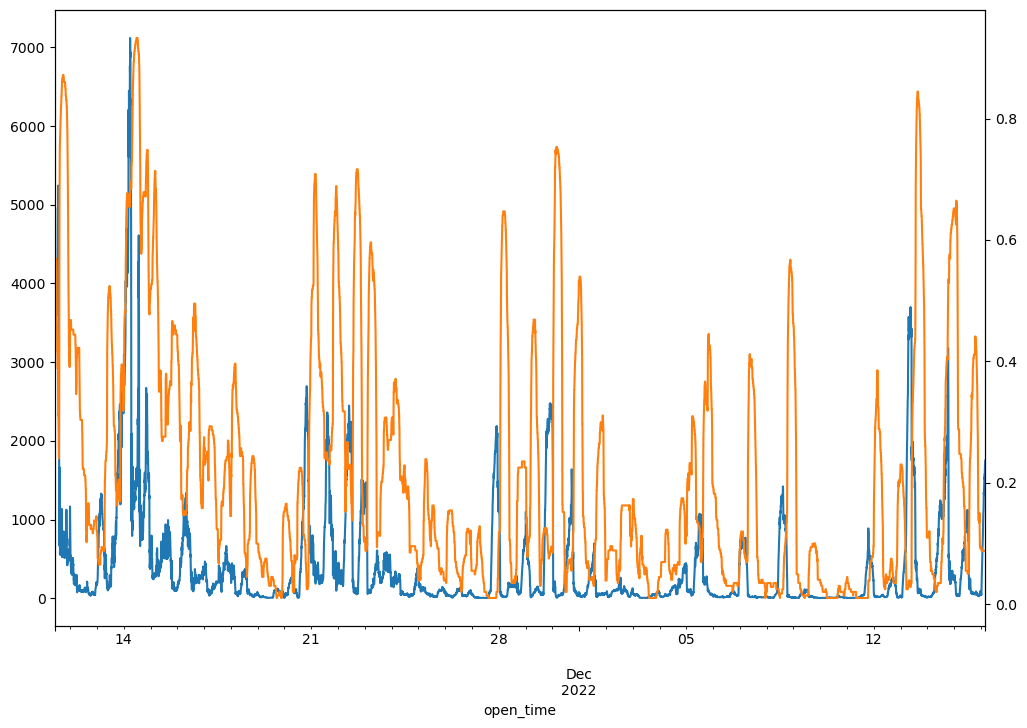

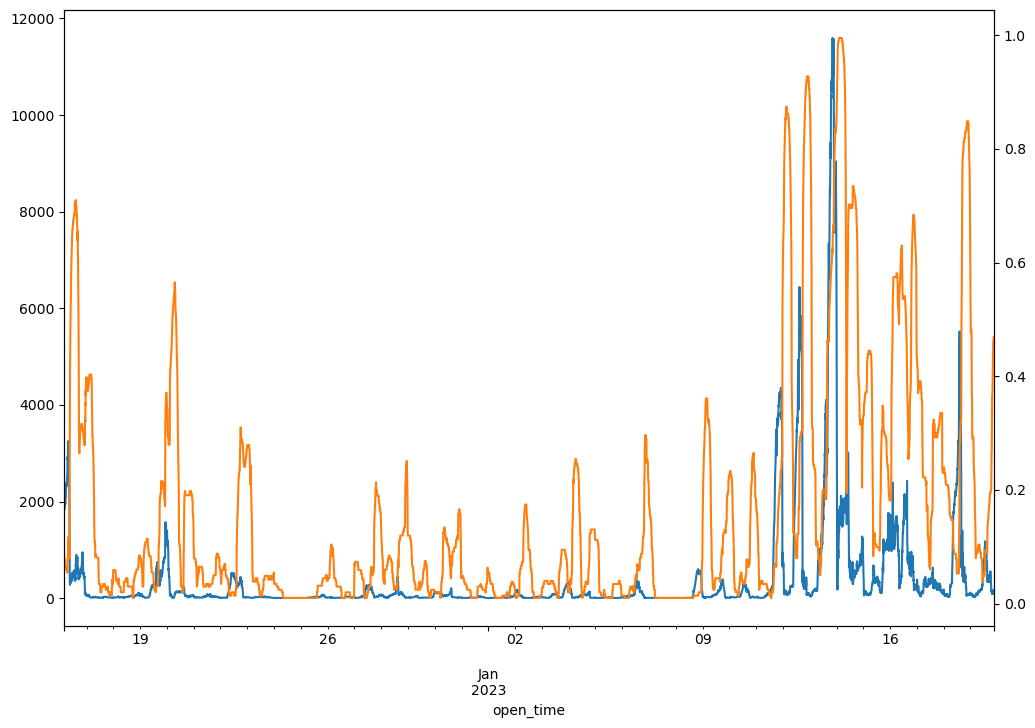

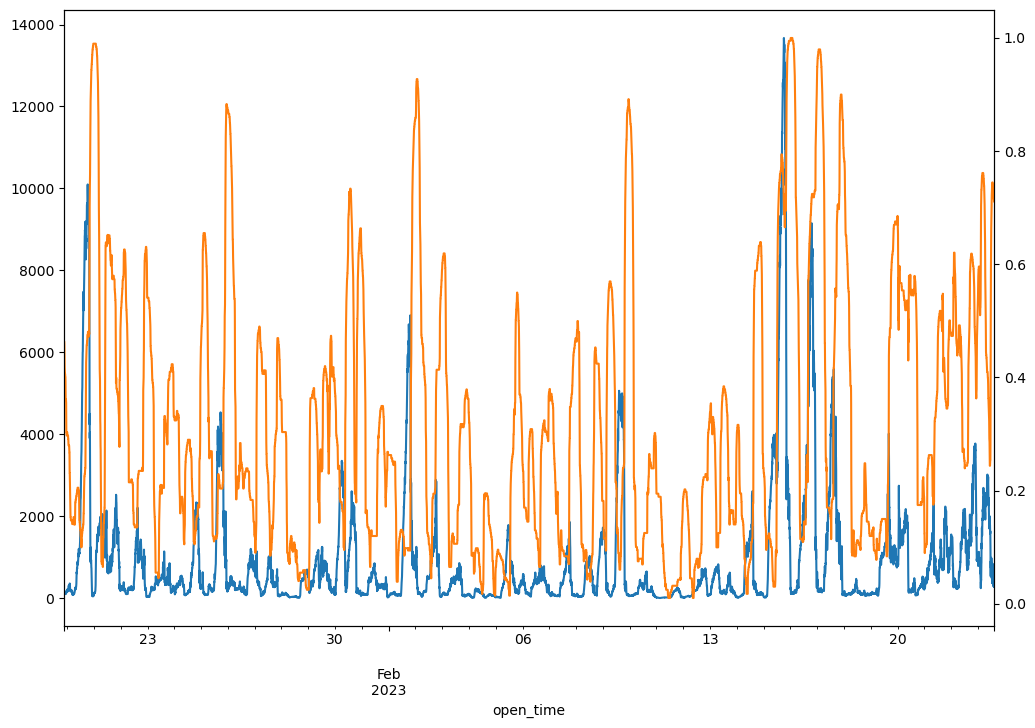

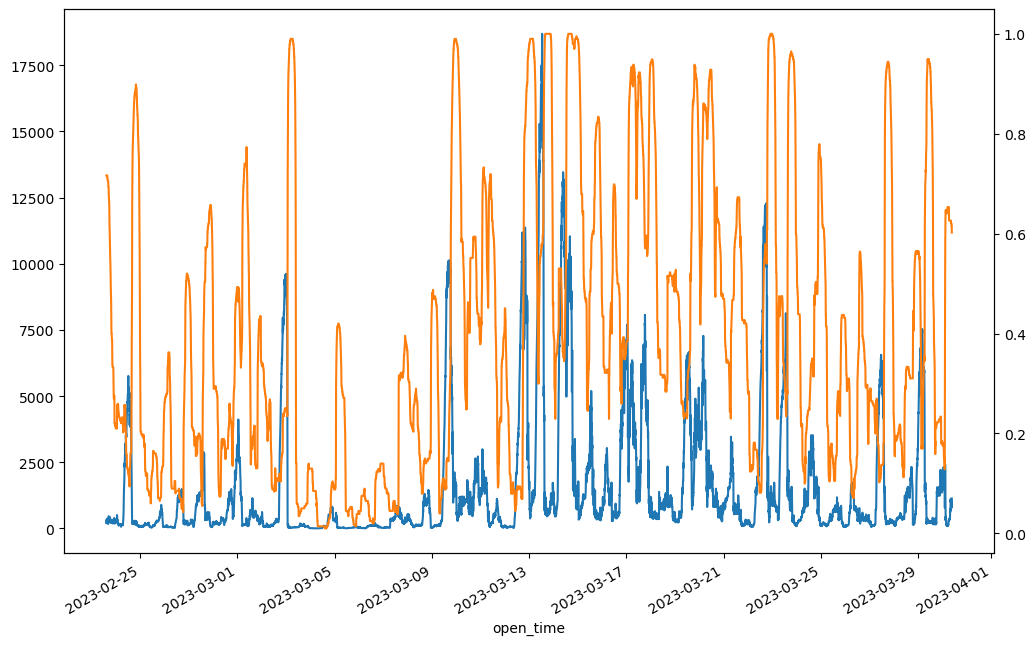

In [171]:
import matplotlib.pyplot as plt

rmse_df.index = rmse_df['open_time']
for i in range(6):
    tmp_df = rmse_df[['weighted_rmse', 'weights']].iloc[(i*10000):(i+1)*10000, :]
    ax = tmp_df['weighted_rmse'].plot(figsize = (12, 8))
    ax = tmp_df['weights'].plot(secondary_y = True)
    plt.show()